## 1. Import Required Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timeit
import warnings

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, LearningCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_variance import VarianceThreshold

from sklearn.model_selection import ValidationCurveDisplay

from scipy.stats import skew


In [3]:
from yellowbrick.model_selection import FeatureImportances, LearningCurve, ValidationCurve
from yellowbrick.classifier import ConfusionMatrix, ROCAUC


In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [5]:
from ucimlrepo import fetch_ucirepo 

In [6]:
warnings.filterwarnings("ignore")

## 2. Define GTID for random seed

In [7]:
def gtid():
    return  903952938

## 3. Load Data
1. Diabetes
2. Customer Churn

In [8]:
# Get the current directory of the notebook
current_dir = os.path.dirname(os.path.abspath('__file__'))

In [10]:

def load_dataset_1(test_size=0.2, random_state=gtid(), id=891):
        print(id)
        cdc_diabetes_health_indicators = fetch_ucirepo(id=id) 
        # data (as pandas dataframes) 
        X = cdc_diabetes_health_indicators.data.features 
        y = cdc_diabetes_health_indicators.data.targets
        temp  = X.copy()
        temp['Diabetes'] = y
        temp.drop_duplicates(inplace = True)
        cols_to_drop = ['Smoker','NoDocbcCost','Sex', 'AnyHealthcare', 'Education', 'Income']
        temp = temp.drop(columns=cols_to_drop)
        # Split the data into training and testing sets
        X,y = temp[[i for i in temp.columns if i!='Diabetes']], temp[['Diabetes']]
        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
  
def load_dataset_2(test_size=0.2, random_state=gtid()):
        train_file_path = os.path.join(current_dir, 'churn', 'train.csv')
        test_file_path = os.path.join(current_dir, 'churn', 'test.csv')
        train_df = pd.read_csv(train_file_path).astype('category')
        test_df = pd.read_csv(test_file_path).astype('category')
        train_df['Gender'] = train_df['Gender'].apply(lambda x: 1 if x=='Female' else 0)
        test_df['Gender'] = test_df['Gender'].apply(lambda x: 1 if x=='Female' else 0)
        train_df.dropna(inplace=True)
        test_df.dropna(inplace=True)
        features  = [i for i in train_df.columns if i not in ['CustomerID', "Churn"]]
        targets = ['Churn']
        X_train, X_test, y_train, y_test = train_df[features], test_df[features], train_df[targets], test_df[targets]
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test


## HELPER FUNCTIONS

In [11]:
def preprocess_data1(X, y, random_state=gtid()):
    """
    Preprocess the data by one-hot encoding non-binary categorical features, applying SMOTE, and scaling using RobustScaler.
    """
    categorical_features=[]
    # Identify categorical and numerical features
    for col in X.columns:
        if X[col].dtype == 'object' or len(X[col].unique()) < 10:  # Assuming categorical if less than 10 unique values
            categorical_features.append(col)
    
    # Remove binary features from numerical features list
    numerical_features = [col for col in X.columns if col not in categorical_features]

    # Define the preprocessor for the pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', RobustScaler(), numerical_features)
        ]
    )
    # Apply the preprocessor to X
    X_preprocessed = preprocessor.fit_transform(X)
    
    nm = NearMiss(version = 1 , n_neighbors = 10)
    x_sm,y_sm= nm.fit_resample(X_preprocessed, y.values.ravel())

    return x_sm,y_sm

def preprocess_data2(X, y, random_state=gtid()):
    """
    Preprocess the data by one-hot encoding non-binary categorical features, applying SMOTE, and scaling using RobustScaler.
    """
    categorical_features=[]
    # Identify categorical and numerical features
    for col in X.columns:
        if X[col].dtype == 'object' or len(X[col].unique()) < 10:  # Assuming categorical if less than 10 unique values
            categorical_features.append(col)
    
    # Remove binary features from numerical features list
    numerical_features = [col for col in X.columns if col not in categorical_features]

    # Define the preprocessor for the pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', RobustScaler(), numerical_features)
        ]
    )
    # Apply the preprocessor to X
    X_preprocessed = preprocessor.fit_transform(X)
    # Apply SMOTE to the preprocessed data
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

    return X_resampled, y_resampled.values.ravel()

def oversample(X, y):
    # Apply SMOTE to the preprocessed data
    smote = SMOTE(random_state=gtid())
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

def undersample(X, y):
    # Apply NearMiss to the preprocessed data
    nm = NearMiss(version = 1 , n_neighbors = 5)
    x_sm, y_sm= nm.fit_resample(X, y)
    return x_sm, y_sm


def tune_hyperparameters(model, param_grid, X_train, y_train, cv=5):
    """
    Tune hyperparameters using GridSearchCV.
    """
    grid_search = GridSearchCV(model, param_grid, refit = True, scoring='f1', verbose = 1, cv=cv)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_

def plot_lc(best_model, x_train, y_train, cv):
    common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": cv,
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_weighted",
}

    LearningCurveDisplay.from_estimator(best_model, **common_params)

def plot_mlp_loss_curve(x_train, y_train, labels):
  """
  Trains a model on provided data and saves loss curves for different labels.
  """
  curves = []
  for label in labels:
     # Create a new model instance with the specified activation function
        model = MLPClassifier(hidden_layer_sizes=(50,50), activation=label,
                              max_iter=200, random_state=gtid(),
                              learning_rate_init=10**(-2),
                              validation_fraction=0.2, tol=0.001,
                              early_stopping=True)
        
        model.fit(x_train, y_train)
        # Extract and save the loss curve for this label
        loss_curve = model.loss_curve_  # Assuming model.history stores loss
        curves.append(loss_curve)
  plt.figure(figsize=(8, 6))  # Adjust figure size as needed
  for y_data, label in zip(curves, labels):
    plt.plot(y_data, label=label, marker='o')
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

def print_grid_search_info(params, param_grid):
    for key, _ in param_grid.items():
        print("Hyparparameter: ", key)
        mean_scores = list(params['mean_test_score'])
        func_list = [i[key] for i in params['params']]
        scores=[]
        for i, val in zip(func_list, mean_scores):
            print(i,": ", val) # Assuming single scoring metric

def plot_svm_loss_curve(x_train, y_train, labels):
  """
  Trains a model on provided data and saves loss curves for different labels.
  """
  curves = []
  for label in labels:
     # Create a new model instance with the specified activation function
        model = SVC(kernel=label,
                      max_iter=100, random_state=gtid(),
                      tol=0.001,  # Tolerance for stopping (adjust as needed)
                      class_weight='balanced')
        model.fit(x_train, y_train)
        # Extract and save the loss curve for this label
        loss_curve = model.loss_curve_  # Assuming model.history stores loss
        curves.append(loss_curve)
  plt.figure(figsize=(8, 6))  # Adjust figure size as needed
  for y_data, label in zip(curves, labels):
    plt.plot(y_data, label=label, marker='o')
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

## Implementing ML Algorithms

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=gtid())

In [12]:
x_tr, x_te, y_tr, y_te = load_dataset_1()
x_train, y_train= preprocess_data1(x_tr, y_tr)
x_test, y_test = preprocess_data1(x_te, y_te)

891


In [13]:
x_tr, x_te, y_tr, y_te = load_dataset_2()
x_train2, y_train2 = preprocess_data2(x_tr, y_tr)
x_test2, y_test2= preprocess_data2(x_te, y_te)

In [14]:
x_train_, x_val, y_train_, y_val=train_test_split(x_train, y_train, test_size=0.2, random_state=gtid())

In [14]:
x_train2_, x_val2, y_train2_, y_val2=train_test_split(x_train2, y_train2, test_size=0.2, random_state=gtid())


### ANN

In [17]:
# Create MLPClassifier with early stopping parameters
model = MLPClassifier(hidden_layer_sizes=(50,50), activation='logistic',
                      max_iter=200, random_state=gtid(),
                      tol=0.001,  # Tolerance for stopping (adjust as needed)
                      early_stopping=True)

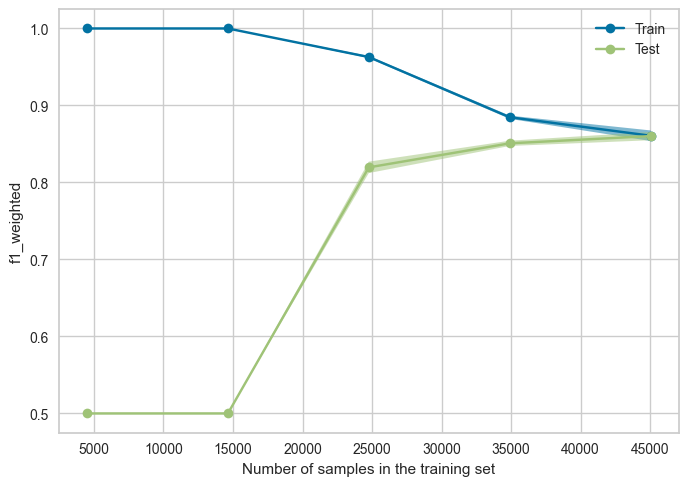

In [23]:
plot_lc(model, x_train, y_train, cv)

#### HyperParameter Tuning

##### Data 1: Diabetes

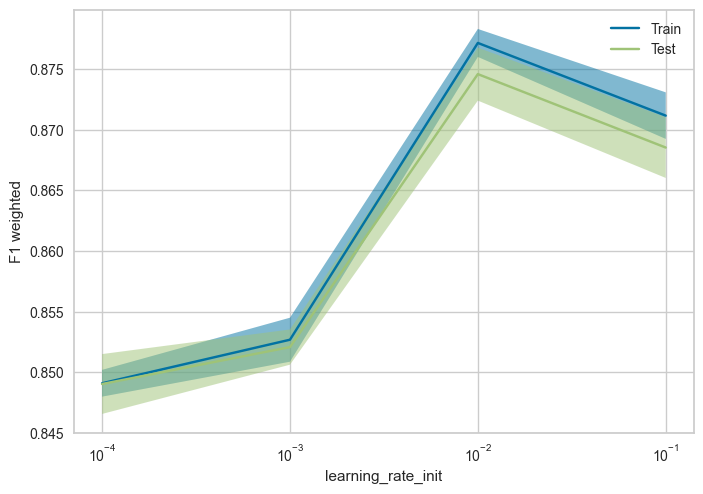

In [24]:
param_range = [0.0001, 0.001, 0.01, 0.1]
ValidationCurveDisplay.from_estimator(
model, x_train_, y_train_, param_name="learning_rate_init", param_range=param_range, scoring='f1_weighted',
cv=cv
)

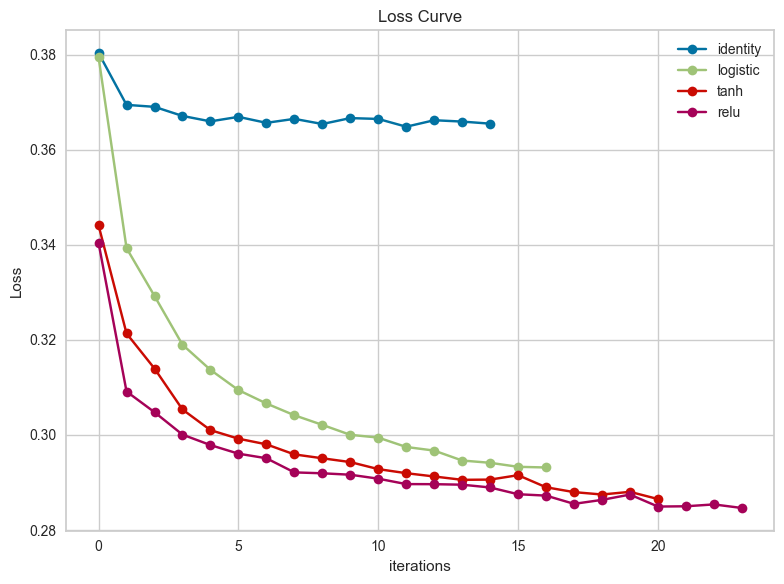

In [26]:
activation_list = ['identity', 'logistic', 'tanh', 'relu']
plot_mlp_loss_curve(x_train, y_train, activation_list)

In [27]:
mlp1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu',
                      max_iter=200, random_state=gtid(),
                      learning_rate_init=10**(-2),
                      tol=0.001,  # Tolerance for stopping (adjust as needed)
                      early_stopping=True)

In [28]:
layer_list=  [(10,), (50,), (100,), (50, 50), (100, 100)]
param_grid = {
    'hidden_layer_sizes': layer_list
    }
best_mlp1, best_params, params = tune_hyperparameters(mlp1, param_grid, x_train_, y_train_, cv=cv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'hidden_layer_sizes': (50, 50)}


In [29]:
print_grid_search_info(params, param_grid)

Hyparparameter:  hidden_layer_sizes
(10,) :  0.8531959667749319
(50,) :  0.8585951861343718
(100,) :  0.8605588760929624
(50, 50) :  0.8617532121357947
(100, 100) :  0.8615504723179221


In [32]:
best_layer1=best_params['hidden_layer_sizes']

In [33]:
best_mlp1_fin=MLPClassifier(
    hidden_layer_sizes=best_layer1, 
    activation='relu',
    learning_rate_init=10**(-2),
    max_iter=200, random_state=gtid(),
    tol=0.001,
    early_stopping=True
)
best_mlp1_fin.fit(x_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, random_state=903952938, tol=0.001)

In [34]:
# Evaluate on the test set
y_test_pred = best_mlp1_fin.predict(x_test)
print("Test Set Evaluation:")
print("F1 Score: ", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall: ", recall_score(y_test, y_test_pred, average='weighted'))
print("ROC AUC: ", roc_auc_score(y_test, y_test_pred))

Test Set Evaluation:
F1 Score:  0.8522577936448803
Accuracy:  0.8527466206499856
Precision:  0.8574776925392444
Recall:  0.8527466206499856
ROC AUC:  0.8527466206499856


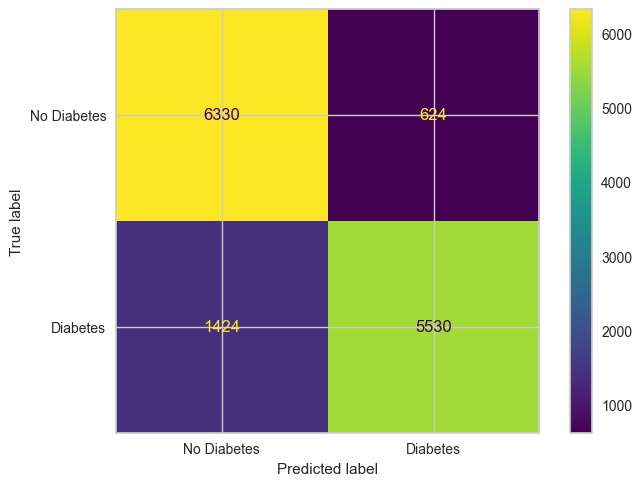

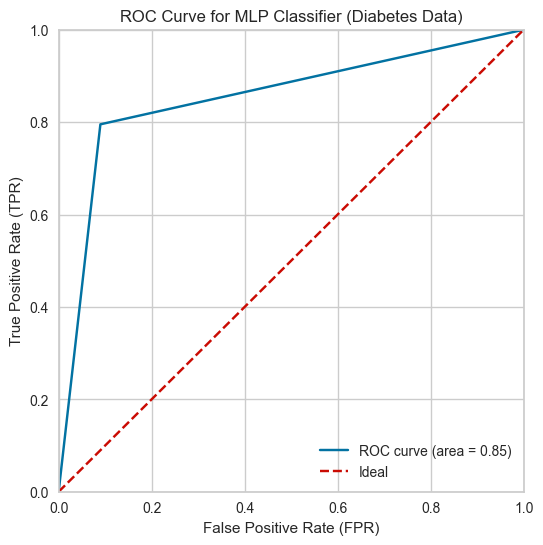

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for MLP Classifier (Diabetes Data)')
plt.legend(loc="lower right")
plt.show()



##### Data 2: Churn

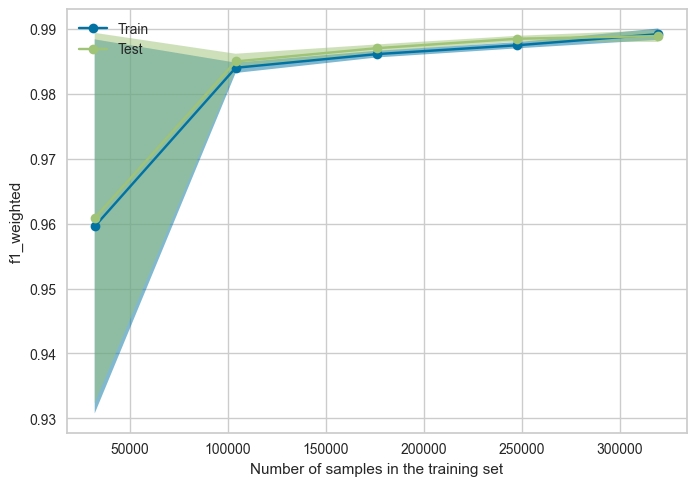

In [30]:
plot_lc(model, x_train2, y_train2, cv)

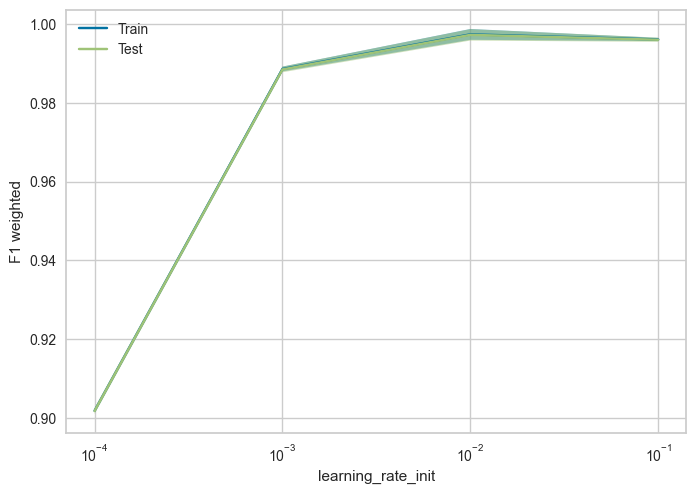

In [18]:
param_range = [0.0001, 0.001, 0.01, 0.1]
ValidationCurveDisplay.from_estimator(
model, x_train2_, y_train2_, param_name="learning_rate_init", param_range=param_range, scoring='f1_weighted',
cv=cv
)

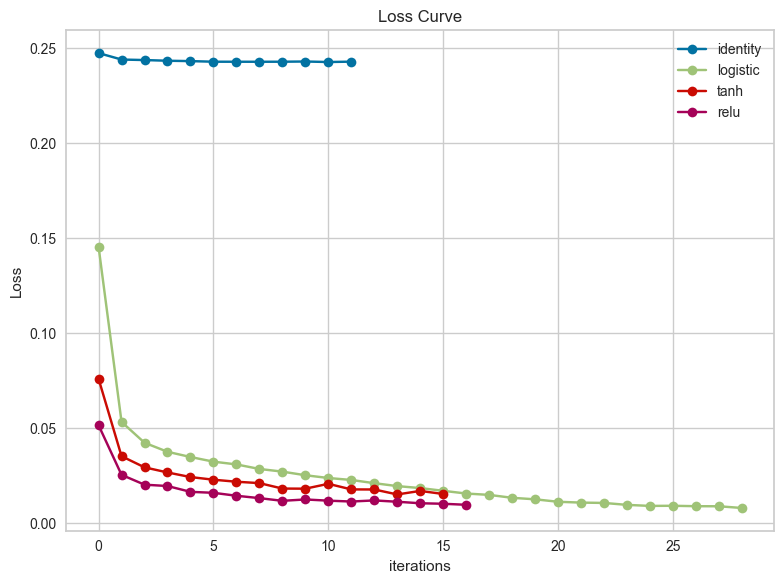

In [20]:
activation_list = ['identity', 'logistic', 'tanh', 'relu']
plot_mlp_loss_curve(x_train2_, y_train2_, activation_list)

In [23]:
layer_list=  [(10,), (50,), (100,), (50, 50), (100, 100)]
param_grid = {
    'hidden_layer_sizes': layer_list
    }
best_mlp2, best_params2, params2 = tune_hyperparameters(model, param_grid, x_train2_, y_train2_, cv=cv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'hidden_layer_sizes': (50,)}


In [24]:
print_grid_search_info(params2, param_grid)

Hyparparameter:  hidden_layer_sizes
(10,) :  0.9886632904916415
(50,) :  0.9893097623035262
(100,) :  0.9885431619942728
(50, 50) :  0.9883575992467065
(100, 100) :  0.9889012176697543


In [30]:
best_layer2=best_params2['hidden_layer_sizes']

In [31]:
lr = 0.01
best_mlp2 = MLPClassifier(hidden_layer_sizes=best_layer2, 
                         activation='relu', 
                         learning_rate_init=lr, 
                         random_state=gtid(),  
                         tol=0.001, 
                         early_stopping=True)
best_mlp2.fit(x_train2, y_train2)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(50,),
              learning_rate_init=0.01, random_state=903952938, tol=0.001)

Test Set Evaluation:
F1 Score:  0.9971281361343199
Accuracy:  0.9971281560368553
Precision:  0.9971419371706436
Recall:  0.9971281560368553
ROC AUC:  0.9971281560368553


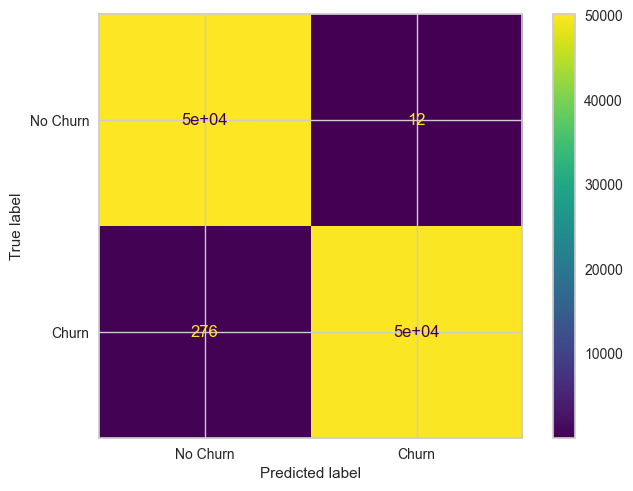

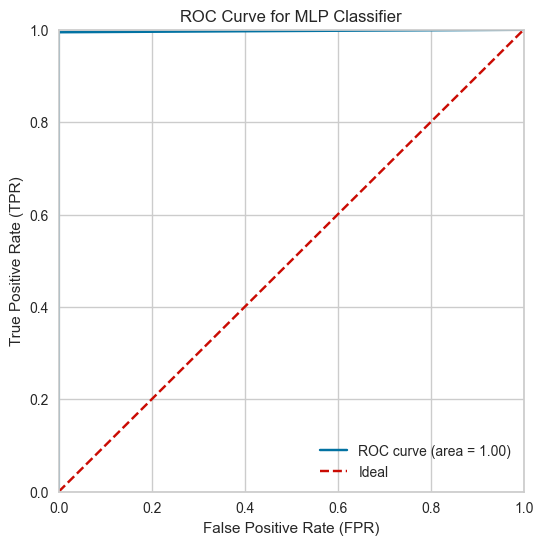

In [32]:
best_mlp2.fit(x_train2, y_train2)
y_test_pred2 = best_mlp2.predict(x_test2)
print("Test Set Evaluation:")
print("F1 Score: ", f1_score(y_test2, y_test_pred2, average='weighted'))
print("Accuracy: ", accuracy_score(y_test2, y_test_pred2))
print("Precision: ", precision_score(y_test2, y_test_pred2, average='weighted'))
print("Recall: ", recall_score(y_test2, y_test_pred2, average='weighted'))
print("ROC AUC: ", roc_auc_score(y_test2, y_test_pred2))

# Plot confusion matrix
cm = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test2, y_test_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for MLP Classifier')
plt.legend(loc="lower right")
plt.show()


### SVM

In [15]:
# Create MLPClassifier with early stopping parameters
svm_model = SVC(kernel='rbf', C=1.0, random_state=gtid())

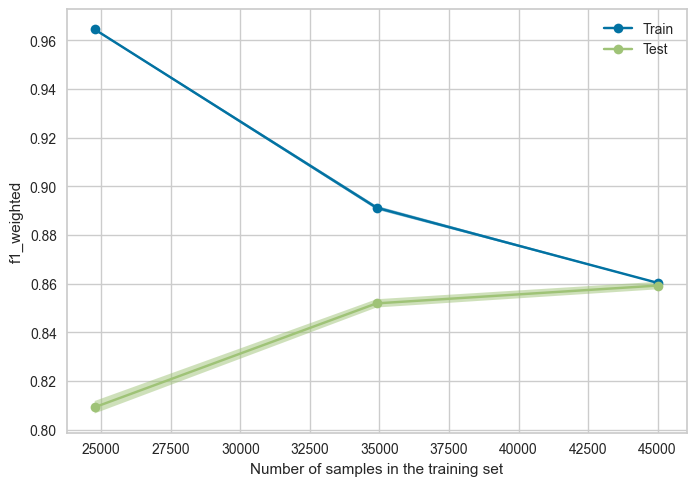

In [66]:
plot_lc(svm_model, x_train, y_train, cv)

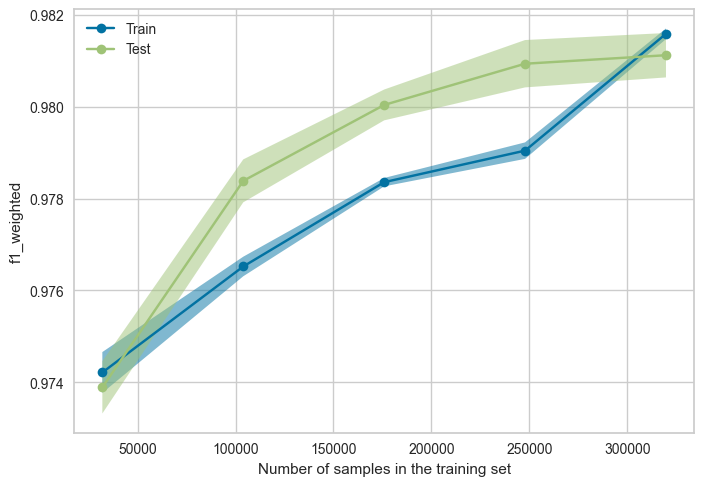

In [67]:
plot_lc(svm_model, x_train2, y_train2, cv)

#### Kernel

##### Data 1: Diabetes

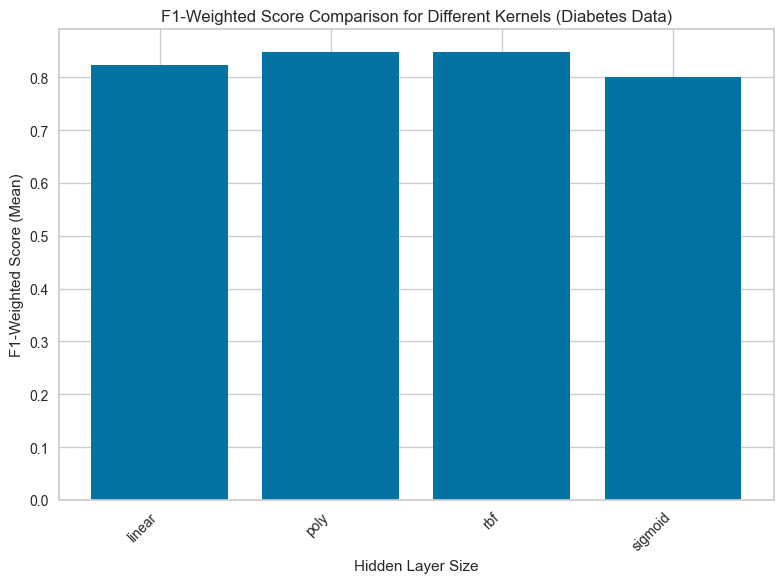

In [68]:
param_range = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = {'kernel': param_range}
grid_search = GridSearchCV(svm_model, param_grid, scoring='f1_weighted')
grid_search.fit(x_train, y_train)
best_kernel = grid_search.best_params_['kernel']
cv_results = grid_search.cv_results_
mean_scores = list(cv_results['mean_test_score'])
activation_functions = [str(i['kernel']) for i in cv_results['params']]

activation_scores=[]
for i, activation in enumerate(activation_functions):
    activation_scores.append(mean_scores[i]) # Assuming single scoring metric

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(activation_functions, activation_scores)
plt.xlabel('Hidden Layer Size')
plt.ylabel('F1-Weighted Score (Mean)')
plt.title('F1-Weighted Score Comparison for Different Kernels (Diabetes Data)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [17]:
# defining parameter range 
param_grid = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}  
best_svm1, best_params1, params1 = tune_hyperparameters(svm_model, param_grid, x_train_, y_train_, cv=cv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'gamma': 1}


In [ ]:
best_svm1 = SVC(kernel='rbf',
              C=1.0,
              gamma=1, random_state=gtid())

In [ ]:
best_svm1.fit(x_train, y_train)
y_test_pred = best_svm1.predict(x_test)
print("Test Set Evaluation:")
print("F1 Score: ", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall: ", recall_score(y_test, y_test_pred, average='weighted'))
print("ROC AUC: ", roc_auc_score(y_test, y_test_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for SVM Classifier - dataset1')
plt.legend(loc="lower right")
plt.show()


##### Data 2: Churn

In [18]:
param_range = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = {'kernel': param_range}
grid_search = GridSearchCV(svm_model, param_grid, scoring='f1_weighted')
grid_search.fit(x_train2, y_train2)
best_kernel = grid_search.best_params_['kernel']
cv_results = grid_search.cv_results_
mean_scores = list(cv_results['mean_test_score'])
activation_functions = [str(i['kernel']) for i in cv_results['params']]

activation_scores=[]
for i, activation in enumerate(activation_functions):
    activation_scores.append(mean_scores[i]) # Assuming single scoring metric

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(activation_functions, activation_scores)
plt.xlabel('Hidden Layer Size')
plt.ylabel('F1-Weighted Score (Mean)')
plt.title('F1-Weighted Score Comparison for Different Kernels (Churn Data)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [18]:
# defining parameter range 
param_grid = {'gamma': [1, 0.1, 0.01, 0.001]}  
best_svm2, best_params2, params2 = tune_hyperparameters(svm_model, param_grid, x_train2_, y_train2_, cv=cv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [16]:
best_svm2 = SVC(kernel='rbf',
              C=0.01,
              max_iter=500, 
              random_state=gtid(),
            #   tol=0.001, 
              gamma=1000)

Test Set Evaluation:
F1 Score:  0.6324262863856387
Accuracy:  0.6571129527141342
Precision:  0.7148243335303186
Recall:  0.6571129527141342
ROC AUC:  0.6571129527141342


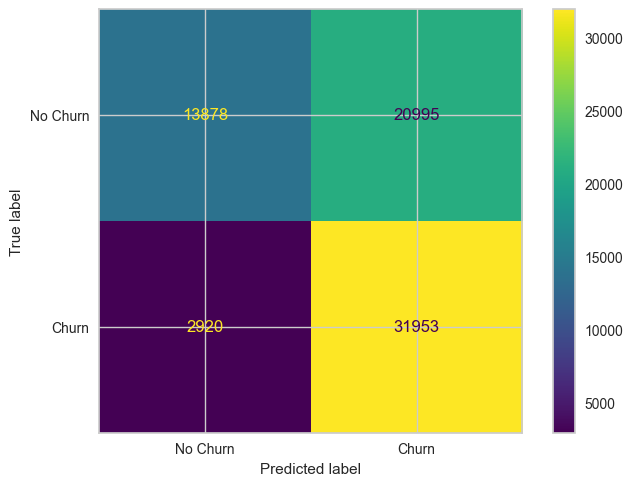

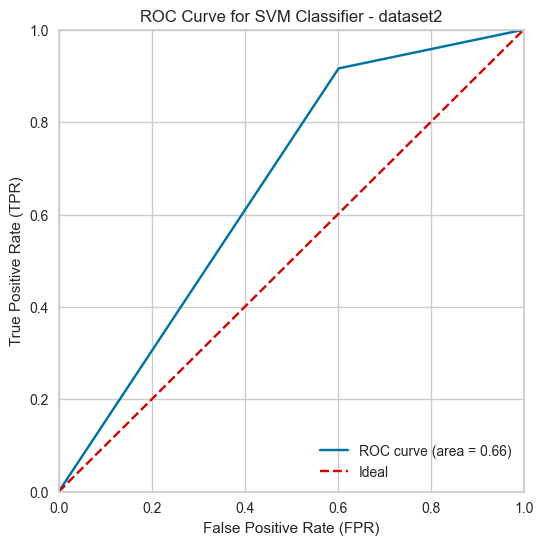

In [17]:
best_svm2.fit(x_train2, y_train2)
y_test_pred2 = best_svm2.predict(x_test2)
print("Test Set Evaluation:")
print("F1 Score: ", f1_score(y_test2, y_test_pred2, average='weighted'))
print("Accuracy: ", accuracy_score(y_test2, y_test_pred2))
print("Precision: ", precision_score(y_test2, y_test_pred2, average='weighted'))
print("Recall: ", recall_score(y_test2, y_test_pred2, average='weighted'))
print("ROC AUC: ", roc_auc_score(y_test2, y_test_pred2))

# Plot confusion matrix
cm = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test2, y_test_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for SVM Classifier - dataset2')
plt.legend(loc="lower right")
plt.show()


### KNN

In [ ]:
model_knn = KNeighborsClassifier(
    n_neighbors=6, 
    leaf_size=30)

In [ ]:
neighbour_params= range(2, 8, 1)
leaf_params= range(3, 30, 3)

##### Data 1: Diabetes

In [ ]:
ValidationCurveDisplay.from_estimator(
model_knn, x_train, y_train, param_name="n_neighbors", param_range=neighbour_params, scoring='f1_weighted', cv=cv
)

In [ ]:
ValidationCurveDisplay.from_estimator(
model_knn, x_train, y_train, param_name="leaf_size", param_range=leaf_params, scoring='f1_weighted', cv=cv
)

In [ ]:
best_knn = KNeighborsClassifier(
    n_neighbors=6,
    leaf_size=30
)


In [ ]:
# Evaluate on the test set
best_knn.fit(x_train, y_train) 
y_test_pred = best_knn.predict(x_test)
print("Test Set Evaluation:")
print("F1 Score: ", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Precision: ", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall: ", recall_score(y_test, y_test_pred, average='weighted'))
print("ROC AUC: ", roc_auc_score(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for KNN - dataset2')
plt.legend(loc="lower right")
plt.show()

##### Data 2: Churn

In [ ]:

ValidationCurveDisplay.from_estimator(
model_knn, x_train2_, y_train2_, param_name="n_neighbors", param_range=neighbour_params, scoring='f1_weighted', cv=cv
)

In [ ]:

ValidationCurveDisplay.from_estimator(
model_knn, x_train2_, y_train2_, param_name="leaf_size", param_range=leaf_params, scoring='f1_weighted', cv=cv
)

In [ ]:
best_knn2 = KNeighborsClassifier(
    n_neighbors=3, 
    leaf_size=10
)

best_knn2.fit(x_train2_, y_train2_) 

In [ ]:
# Evaluate on the test set
y_test_pred2 = best_knn2.predict(x_test2)
print("Test Set Evaluation:")
print("F1 Score: ", f1_score(y_test2, y_test_pred2, average='weighted'))
print("Accuracy: ", accuracy_score(y_test2, y_test_pred2))
print("Precision: ", precision_score(y_test2, y_test_pred2, average='weighted'))
print("Recall: ", recall_score(y_test2, y_test_pred2, average='weighted'))
print("ROC AUC: ", roc_auc_score(y_test2, y_test_pred2))
# Plot confusion matrix
cm = confusion_matrix(y_test2, y_test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test2, y_test_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for KNN - dataset2')
plt.legend(loc="lower right")
plt.show()
